# INTRODUCTION

<div style="text-align: center;">
    <img src="img/Paris-2024.jpg" width="500" height="250" alt="Alt text" title="Optional title">
</div>


In this Olympic year of 2024, the excitement around the Olympic Games reaches its peak. Athletes from all over the globe are fine-tuning their preparations, bringing with them a rich mosaic of data including gender, age, height, weight, country, as well as socio-economic and public health indicators such as CO2 emissions, GDP, and mortality rate. It is in this context that we launch a challenge to predict Olympic medals, leveraging historical data to forecast future performances.

This starting kit is designed to introduce you to the development of a sophisticated predictive model, aiming to estimate the medal of each athlete will win. To achieve this, we utilize a comprehensive dataset, compiled from detailed analyses available on Kaggle, which contains information on athletes and the conditions of their respective countries, collected from various Olympic competitions ranging from 1968 to 2016. Participants are thus invited to dive into this dataset to design models capable of translating these diverse pieces of information into accurate forecasts for the 2024 Games, establishing a bridge between data analysis and athletic feats on the global stage.

As we prepare to celebrate the Olympic spirit in 2024, this challenge offers a unique opportunity to combine a passion for sport with expertise in data science. Good luck to all participants!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from category_encoders import BinaryEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import BaggingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

### Data Acquisition

The data used in this project comes from two main sources. The first two datasets, which contain historical information on Olympic athletes and results, as well as data on National Olympic Committee (NOC) regions, were downloaded from the Kaggle platform. These datasets are publicly available and have been compiled into a collection titled "120 years of Olympic history: athletes and results," which can be found at the following link: [Kaggle - 120 years of Olympic history](https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results).

The third dataset, containing world development indicators, was acquired from the World Bank via their Open Data portal. This resource provides broad access to a vast range of global development data, including economic, social, demographic, and environmental indicators. The direct link to this dataset is: [World Bank - World Development Indicators](https://databank.worldbank.org/source/world-development-indicators).

In [2]:
df_athletes = pd.read_csv('data/athlete_events.csv')
df_athletes

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN


In [4]:
noc_regions=  pd.read_csv('data/noc_regions.csv')
noc_regions

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN
...,...,...,...
225,YEM,Yemen,NaN
226,YMD,Yemen,South Yemen
227,YUG,Serbia,Yugoslavia
228,ZAM,Zambia,NaN


In [5]:
countries_info = pd.read_csv('data/countries_info.csv')
countries_info

,Country Name,Country Code,Series Name,Series Code,1966 [YR1966],1967 [YR1967],1968 [YR1968],1969 [YR1969],1970 [YR1970],1971 [YR1971],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016]
0,Argentina,ARG,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,58.684,59.825,60.988,62.583,64.638,64.962,...,64,63.078,60.281,62.62,64.877,64.07,69.167,67.791,65.395,61.852
1,Argentina,ARG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,10.2787574725073,9.98038631665412,9.72127698537181,9.18580964838541,9.6375609641048,10.8658823843399,...,4.56858960891786,10.2066467144411,10.328166939117,8.36248661002826,7.93875427420938,6.93557229126392,6.05291843670451,6.71270351428559,5.1566859021408,6.26456582010254
2,Argentina,ARG,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,..,..,..,..,..,..,...,10.6275077833219,10.8554522104452,11.0833966376027,11.3113410647603,11.5392854919178,11.7672299190411,12.9075342465753,12.9075342465753,12.9075342465753,12.9075342465753
3,Argentina,ARG,Births attended by skilled health staff (% of ...,SH.STA.BRTC.ZS,..,..,..,..,..,..,...,98.4,98.9,98.7,99.1,99.1,99.4,97,99.6,99.6,98.4
4,Argentina,ARG,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,..,..,..,..,..,..,...,3.34187706655833,3.10048866797723,3.33489087930132,3.65608487008491,3.73671686472615,3.92426184145235,4.34225013023383,4.20911189491323,4.30191380564475,4.20181586904703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14633,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Preparation
After acquiring the data from Kaggle and the World Bank, the next phase was to integrate and prepare these datasets to create a consolidated dataset that would serve as the basis for our in-depth analyses

### Step 1: Merging with Regional Data
The dataset of athletes was merged with regional information to associate each athlete with their country of origin. This involved an inner join on the common 'NOC' column, followed by renaming the 'region' column to 'Country'. We then removed redundant or unnecessary columns for our analysis, such as the athlete's name and notes, to simplify our dataset.

In [6]:
# Merge the DataFrames on 'NOC' column and rename 'region' to 'Country'
df_data = pd.merge(df_athletes, noc_regions, how='inner', on='NOC').rename(columns={'region': 'Country'})

# Drop redundant columns
columns_to_drop = ['Name', 'ID', 'NOC', 'Team', 'Games', 'notes', 'City']
df_data.drop(columns=columns_to_drop, inplace=True)
df_data

,Sex,Age,Height,Weight,Year,Season,Sport,Event,Medal,Country
0,M,24.0,180.0,80.0,1992,Summer,Basketball,Basketball Men's Basketball,NaN,China
1,M,23.0,170.0,60.0,2012,Summer,Judo,Judo Men's Extra-Lightweight,NaN,China
2,M,24.0,NaN,NaN,1920,Summer,Football,Football Men's Football,NaN,Denmark
3,M,34.0,NaN,NaN,1900,Summer,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark
4,F,21.0,185.0,82.0,1988,Winter,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands
...,...,...,...,...,...,...,...,...,...,...
270762,M,29.0,179.0,89.0,1976,Winter,Luge,Luge Mixed (Men)'s Doubles,NaN,Poland
270763,M,27.0,176.0,59.0,2014,Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN,Poland
270764,M,27.0,176.0,59.0,2014,Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN,Poland
270765,M,30.0,185.0,96.0,1998,Winter,Bobsleigh,Bobsleigh Men's Four,NaN,Poland


### Step 2: Preparing the Country Dataset
Parallelly, we prepared the country dataset by selecting specific series of data that reflect pertinent socio-economic indicators. To ensure temporal consistency with the athlete data, we extracted years from columns and reorganized the dataframe in a pivot manner to align each socio-economic indicator with its corresponding year.

In [7]:
# Display all attributes of the Series Name feature
unique_series = countries_info['Series Name'].unique()


In [8]:
desired_series_names = {
    'GDP (current US$)': 'GDP',
    'CO2 emissions (metric tons per capita)': 'CO2',
    'GNI per capita, Atlas method (current US$)': 'GNI',
    'Life expectancy at birth, total (years)': 'Life_expt',
    'Mortality rate, under-5 (per 1,000 live births)': 'mort_rate',
    'Population, total': 'population',
    'Immunization, measles (% of children ages 12-23 months)': 'immunization'
}

# Filter based on desired series names
condition = countries_info['Series Name'].isin(desired_series_names.keys())
filtered_df = countries_info[condition]

# Replace '..' with NaN
filtered_df = filtered_df.replace('..', np.nan)

# Drop unnecessary column
filtered_df.drop(columns=['Series Code'], inplace=True)

# Extract years from columns
year_columns = filtered_df.columns[3:].str.extract(r'\[YR(\d{4})\]')

# Add only the extracted years to the DataFrame columns
filtered_df.columns = filtered_df.columns[:3].tolist() + year_columns.dropna().squeeze().tolist()

# Mapping series names
filtered_df['Series Name'] = filtered_df['Series Name'].map(desired_series_names)


In [9]:
melted_df = pd.melt(filtered_df, id_vars=['Country Name', 'Country Code', 'Series Name'], var_name='Year', value_name='Value')
melted_df['Value'] = pd.to_numeric(melted_df['Value'], errors='coerce')

# Pivot the DataFrame
pivoted_df = melted_df.pivot_table(index=['Country Name', 'Country Code', 'Year'], columns='Series Name', values='Value').reset_index()

pivoted_df

Series Name,Country Name,Country Code,Year,CO2,GDP,GNI,Life_expt,immunization,mort_rate,population
0,Afghanistan,AFG,1966,NaN,1.400000e+09,NaN,35.453,NaN,323.9,9783147.0
1,Afghanistan,AFG,1967,NaN,1.673333e+09,NaN,35.924,NaN,318.4,10010030.0
2,Afghanistan,AFG,1968,NaN,1.373333e+09,NaN,36.418,NaN,312.8,10247780.0
3,Afghanistan,AFG,1969,NaN,1.408889e+09,NaN,36.910,NaN,307.2,10494489.0
4,Afghanistan,AFG,1970,NaN,1.748887e+09,NaN,37.418,NaN,301.9,10752971.0
...,...,...,...,...,...,...,...,...,...,...
8201,Zimbabwe,ZWE,2006,0.794113,5.443896e+09,290.0,45.364,68.0,95.6,12330490.0
8202,Zimbabwe,ZWE,2013,0.901248,1.909102e+10,1200.0,57.458,93.0,66.2,13555422.0
8203,Zimbabwe,ZWE,2014,0.866838,1.949552e+10,1210.0,58.846,92.0,62.6,13855753.0
8204,Zimbabwe,ZWE,2015,0.846962,1.996312e+10,1220.0,59.591,86.0,60.5,14154937.0


Before the final merge with the country dataset, the year columns in both datasets were converted to strings to ensure an accurate join. This allowed us to associate each athlete not only with their sports performance but also with the socio-economic context of their country for the relevant year.

In [10]:
df_data['Year'] = df_data['Year'].astype(str)
pivoted_df['Year'] = pivoted_df['Year'].astype(str)

### Step 3: Merging Country Data and Creating the Final Dataset
Datasets were merged to create our consolidated dataset. This merge was carried out by aligning the data on the 'Year' and 'Country' columns, ensuring that each athlete entry was enriched with relevant socio-economic information from their country for the corresponding year.

In [11]:
final_df = pd.merge(df_data, pivoted_df,
                    left_on=['Year', 'Country'],
                    right_on=['Year', 'Country Name'])


final_df.drop(columns=['Country Name','Country Code'], inplace=True)
final_df = final_df[['Sex', 'Age', 'Height', 'Weight', 'Year', 'Season', 'Sport', 'Event', 'Country', 'CO2', 'GDP', 'GNI', 'Life_expt', 'immunization', 'mort_rate', 'population', 'Medal']]
final_df

,Sex,Age,Height,Weight,Year,Season,Sport,Event,Country,CO2,GDP,GNI,Life_expt,immunization,mort_rate,population,Medal
0,F,21.0,185.0,82.0,1988,Winter,Speed Skating,Speed Skating Women's 500 metres,Netherlands,NaN,2.619105e+11,18190.0,76.890244,94.0,8.9,14760094.0,NaN
1,F,21.0,185.0,82.0,1988,Winter,Speed Skating,"Speed Skating Women's 1,000 metres",Netherlands,NaN,2.619105e+11,18190.0,76.890244,94.0,8.9,14760094.0,NaN
2,M,26.0,186.0,96.0,2002,Winter,Ice Hockey,Ice Hockey Men's Ice Hockey,Finland,12.198539,1.404045e+11,25620.0,78.119512,96.0,4.1,5200598.0,NaN
3,M,31.0,172.0,70.0,2000,Summer,Badminton,Badminton Men's Singles,Finland,10.644373,1.260195e+11,26480.0,77.465854,96.0,4.3,5176209.0,NaN
4,F,34.0,159.0,55.5,2000,Summer,Sailing,Sailing Women's Windsurfer,Finland,10.644373,1.260195e+11,26480.0,77.465854,96.0,4.3,5176209.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82070,F,33.0,171.0,69.0,2016,Summer,Basketball,Basketball Women's Basketball,Belarus,5.829464,4.772355e+10,5640.0,73.826829,98.0,3.9,9469379.0,NaN
82071,M,27.0,176.0,59.0,2014,Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",Poland,7.516889,5.390805e+11,13470.0,77.602439,97.0,5.0,38011735.0,NaN
82072,M,27.0,176.0,59.0,2014,Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Team",Poland,7.516889,5.390805e+11,13470.0,77.602439,97.0,5.0,38011735.0,NaN
82073,M,30.0,185.0,96.0,1998,Winter,Bobsleigh,Bobsleigh Men's Four,Poland,8.235526,1.746858e+11,4360.0,72.997561,97.0,10.9,38663481.0,NaN


#### Step 4: Adding Custom Columns
Additional columns were added to enrich the analysis:

#### BMI Calculation :
BMI, an indicator of physical fitness, was calculated using the height and weight of the athletes. This new metric was inserted into the dataset to allow for a more nuanced assessment of the athletes' physical condition in relation to their performance.

#### Number of Athletes per Country:
Another dimension added was the number of athletes representing each country, a data point that could reflect the depth of talent or resources invested in athletic training across nations.

In [12]:
# Insert BMI
height = final_df['Height']
weight = final_df['Weight']
bmi = weight / ((height/100)**2)
final_df.insert(4, 'BMI', bmi)


index_before_last_column = final_df.columns.get_loc(final_df.columns[-1])

# Insert number of athletes sent by country as a new column
final_df.insert(index_before_last_column, 'Number of athletes', df_data.groupby('Country')['Country'].transform('count'))

In [13]:
df = final_df
df

,Sex,Age,Height,Weight,BMI,Year,Season,Sport,Event,Country,CO2,GDP,GNI,Life_expt,immunization,mort_rate,population,Number of athletes,Medal
0,F,21.0,185.0,82.0,23.959094,1988,Winter,Speed Skating,Speed Skating Women's 500 metres,Netherlands,NaN,2.619105e+11,18190.0,76.890244,94.0,8.9,14760094.0,5826.0,NaN
1,F,21.0,185.0,82.0,23.959094,1988,Winter,Speed Skating,"Speed Skating Women's 1,000 metres",Netherlands,NaN,2.619105e+11,18190.0,76.890244,94.0,8.9,14760094.0,5826.0,NaN
2,M,26.0,186.0,96.0,27.748873,2002,Winter,Ice Hockey,Ice Hockey Men's Ice Hockey,Finland,12.198539,1.404045e+11,25620.0,78.119512,96.0,4.1,5200598.0,3570.0,NaN
3,M,31.0,172.0,70.0,23.661439,2000,Summer,Badminton,Badminton Men's Singles,Finland,10.644373,1.260195e+11,26480.0,77.465854,96.0,4.3,5176209.0,3570.0,NaN
4,F,34.0,159.0,55.5,21.953246,2000,Summer,Sailing,Sailing Women's Windsurfer,Finland,10.644373,1.260195e+11,26480.0,77.465854,96.0,4.3,5176209.0,5839.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82070,F,33.0,171.0,69.0,23.597004,2016,Summer,Basketball,Basketball Women's Basketball,Belarus,5.829464,4.772355e+10,5640.0,73.826829,98.0,3.9,9469379.0,927.0,NaN
82071,M,27.0,176.0,59.0,19.047004,2014,Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",Poland,7.516889,5.390805e+11,13470.0,77.602439,97.0,5.0,38011735.0,927.0,NaN
82072,M,27.0,176.0,59.0,19.047004,2014,Winter,Ski Jumping,"Ski Jumping Men's Large Hill, Team",Poland,7.516889,5.390805e+11,13470.0,77.602439,97.0,5.0,38011735.0,927.0,NaN
82073,M,30.0,185.0,96.0,28.049671,1998,Winter,Bobsleigh,Bobsleigh Men's Four,Poland,8.235526,1.746858e+11,4360.0,72.997561,97.0,10.9,38663481.0,927.0,NaN


## Feature Engineering: Advanced Data Preprocessing

### Step 1: Handling Missing Values
The first step involves addressing missing values that could bias our analyses or models. We utilized 'SimpleImputer' from sklearn to impute missing values in numerical columns with the mean and in categorical columns with the most frequent modality. Specifically, for the 'Medal' column, we replaced missing values with 'None', ensuring that every entry has a value for this variable.

In [14]:
#List of categorical columns excluding 'Medal'
categorical_cols = ['Sex', 'Year', 'Season', 'Sport', 'Event', 'Country']

#Replace missing values in 'Medal' with 'None' separately
df['Medal'] = df['Medal'].fillna('None')

# Imputation for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
numerical_imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

#Imputation for categorical columns
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

### Step 2: Correcting Skewed Distributions

Next, we assessed the symmetry of the distributions of our numerical variables. For variables with skewness exceeding a threshold of 0.70, we applied a logarithmic transformation to normalize their distribution. The aim of this approach was to reduce the impact of extreme values.

In [15]:
skewness = df[numerical_cols].skew()
skew_threshold = 0.70
updated_numerical_columns = []

for column in numerical_cols:
    if abs(skewness[column]) > skew_threshold:
        df[column] = np.log1p(df[column])
        updated_numerical_columns.append(column)
    else:
        updated_numerical_columns.append(column)


### Step 3: Categorical Variable Encoding
We addressed categorical variables through various encoding techniques to transform them into numerical formats:


*  Binary encoding for 'Event', 'Sport', and 'Country' variables via BinaryEncoder, useful for managing categories with a large number of levels without significantly increasing the dataset's dimensionality.
*  One-hot encoding for 'Sex' and 'Season', creating binary indicator variables for each category.
*  Label encoding for 'Medal', where each medal is mapped to a specific numerical value, allowing for an ordered interpretation of the results

In [16]:
binary_encoder = BinaryEncoder(cols=['Event', 'Sport', 'Country'])
df_binary_encoded = binary_encoder.fit_transform(df[['Event', 'Sport', 'Country']])

# One-hot encoding for ['Sex', 'Season']
df_one_hot_encoded = pd.get_dummies(df[['Sex', 'Season']])

# Label encoding for 'Medal'
target_labels = {'Gold': 1, 'Silver': 2, 'Bronze': 3, 'None': 4}
df['Medal'] = df['Medal'].map(target_labels)

# Concatenate all encoded features
df_encoded = pd.concat([df_binary_encoded, df_one_hot_encoded, df['Medal']], axis=1)

final_df = pd.concat([df[updated_numerical_columns], df_encoded,df['Year']], axis=1)


<div style="text-align: center;">
    <img src="img/Dataset_JO.jpg" width="1000" height="900" alt="Alt text" title="Optional title">
</div>


### DATA EXPLORATION AND MODELING

In [18]:
final_df.head()

,Age,Height,Weight,BMI,CO2,GDP,GNI,Life_expt,immunization,mort_rate,...,Country_4,Country_5,Country_6,Country_7,Sex_F,Sex_M,Season_Summer,Season_Winter,Medal,Year
0,3.091042,185.0,4.418841,3.217238,2.125768,26.291269,9.808682,4.355301,4.553877,2.292535,...,0,0,0,1,True,False,False,True,4,1988
1,3.091042,185.0,4.418841,3.217238,2.125768,26.291269,9.808682,4.355301,4.553877,2.292535,...,0,0,0,1,True,False,False,True,4,1988
2,3.295837,186.0,4.574711,3.358599,2.580106,25.667793,10.151168,4.370960,4.574711,1.629241,...,0,0,1,0,False,True,False,True,4,2002
3,3.465736,172.0,4.262680,3.205241,2.454823,25.559703,10.184183,4.362664,4.574711,1.667707,...,0,0,1,0,False,True,True,False,4,2000
4,3.555348,159.0,4.034241,3.133459,2.454823,25.559703,10.184183,4.362664,4.574711,1.667707,...,0,0,1,0,True,False,True,False,4,2000


Our final dataset has 41 variables, including the target, and 82,075 rows.

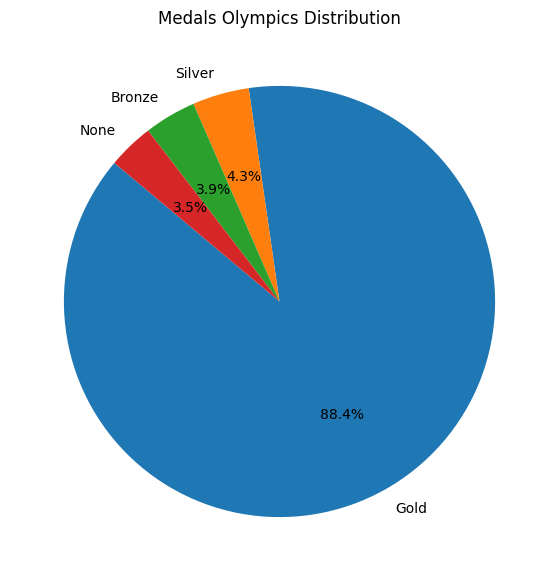

In [19]:
medal_counts = final_df['Medal'].value_counts()
labels_custom = ['Gold', 'Silver', 'Bronze','None'] 

plt.figure(figsize=(7, 7)) 
plt.pie(medal_counts, labels=labels_custom, autopct='%1.1f%%', startangle=140)

plt.title("Medals Olympics Distribution")

plt.show()

More than 88% of our athletes have won a gold medal. The other classes are truly minority. This will push us to use models of the GBM (Gradient Boosting Machines) type.

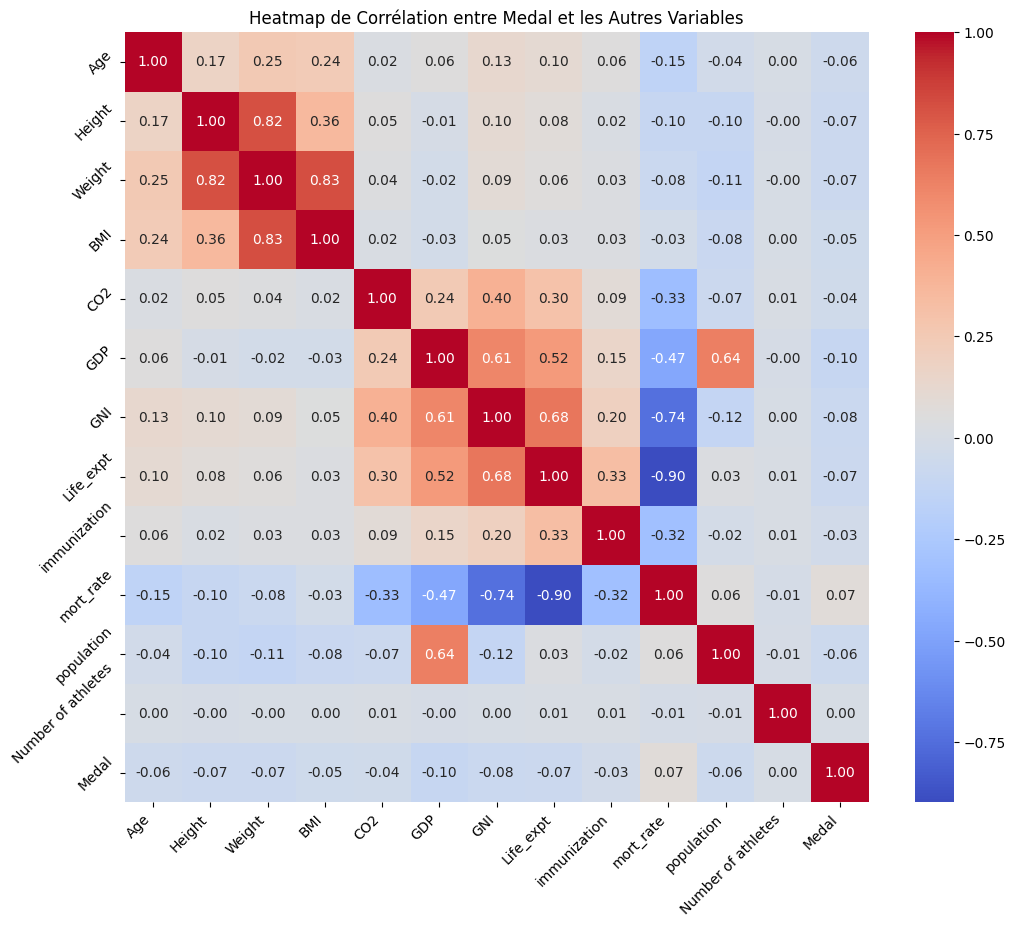

In [20]:
cols = ['Age', 'Height', 'Weight', 'BMI', 'CO2', 'GDP', 'GNI', 'Life_expt',
        'immunization', 'mort_rate', 'population', 'Number of athletes', 'Medal']

df_num = final_df[cols]

corr = df_num.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.title('Heatmap de Corrélation entre Medal et les Autres Variables')

plt.show()


On this graph, we can observe that 'Medal' does not seem to have a strong correlation with most of the other variables, as indicated by the values close to zero. However, there are notable correlations between some of the other variables, for example, 'Weight' and 'BMI' have a very high correlation between them, which makes sense because BMI is calculated from a person's weight and height.

The variables 'GDP', 'GNI', and 'Life_expt' also appear to be strongly correlated with each other, suggesting that these economic and health indicators are related in the data. Similarly, there is a significant negative correlation between 'mort_rate' (mortality rate) and the previous three variables, which is also expected because countries with higher GDP and GNI and better life expectancy often have lower mortality rates.

In [21]:
final_df['Sex_F'] = final_df['Sex_F'].astype(int)
final_df['Sex_M'] = final_df['Sex_M'].astype(int)
final_df['Season_Summer'] = final_df['Season_Summer'].astype(int)
final_df['Season_Winter'] = final_df['Season_Winter'].astype(int)

In [22]:
X = final_df.drop('Medal', axis=1)
y = final_df['Medal']

In [23]:
categorical_features = [
    'Event_0', 'Event_1', 'Event_2', 'Event_3', 'Event_4', 'Event_5',
    'Event_6', 'Event_7', 'Event_8', 'Sport_0', 'Sport_1', 'Sport_2',
    'Sport_3', 'Sport_4', 'Sport_5', 'Country_0', 'Country_1', 'Country_2',
    'Country_3', 'Country_4', 'Country_5', 'Country_6', 'Country_7'
]

categorical_features += ['Sex_F', 'Sex_M', 'Season_Summer', 'Season_Winter']

numerical_features = [
    'Age', 'Height', 'Weight', 'BMI', 'CO2', 'GDP', 'GNI', 'Life_expt',
    'immunization', 'mort_rate', 'population', 'Number of athletes', 'Year'
]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])



In [24]:
categorical_transformer = 'passthrough'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

#  imbalanced-learn pipeline with SMOTE and CatBoost
clf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', CatBoostClassifier(verbose=0))
])


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
clf.fit(X_train, y_train)
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Height', 'Weight',
                                                   'BMI', 'CO2', 'GDP', 'GNI',
                                                   'Life_expt', 'immunization',
                                                   'mort_rate', 'population',
                                                   'Number of athletes',
                                                   'Year']),
                                                 ('cat', 'passthrough',
                                                  ['Event_0', 'Event_1',
                                                   'Event_2', 'Event_3',
                                                   'Event_4', 'Event_5',
                                                   'Event_6', 'Event_7',
                                                   'Event_8', 'Sport_0',
                                                   'Sport_1', 'Sport_2',
                                                   'Sport_3', 'Sport_4',
                                                   'Sport_5', 'Country_0',
                                                   'Country_1', 'Country_2',
                                                   'Country_3', 'Country_4',
                                                   'Country_5', 'Country_6',
                                                   'Country_7', 'Sex_F',
                                                   'Sex_M', 'Season_Summer',
                                                   'Season_Winter'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x2953c6690>)])

In [27]:
y_pred = clf.predict(X_test)

In [28]:
y_pred.shape

(16415, 1)

In [29]:
accuracy_score(y_test, y_pred)

0.9159914712153518

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.78      0.43      0.56       600
           2       0.72      0.37      0.49       618
           3       0.80      0.37      0.50       725
           4       0.93      0.99      0.96     14472

    accuracy                           0.92     16415
   macro avg       0.81      0.54      0.63     16415
weighted avg       0.91      0.92      0.90     16415



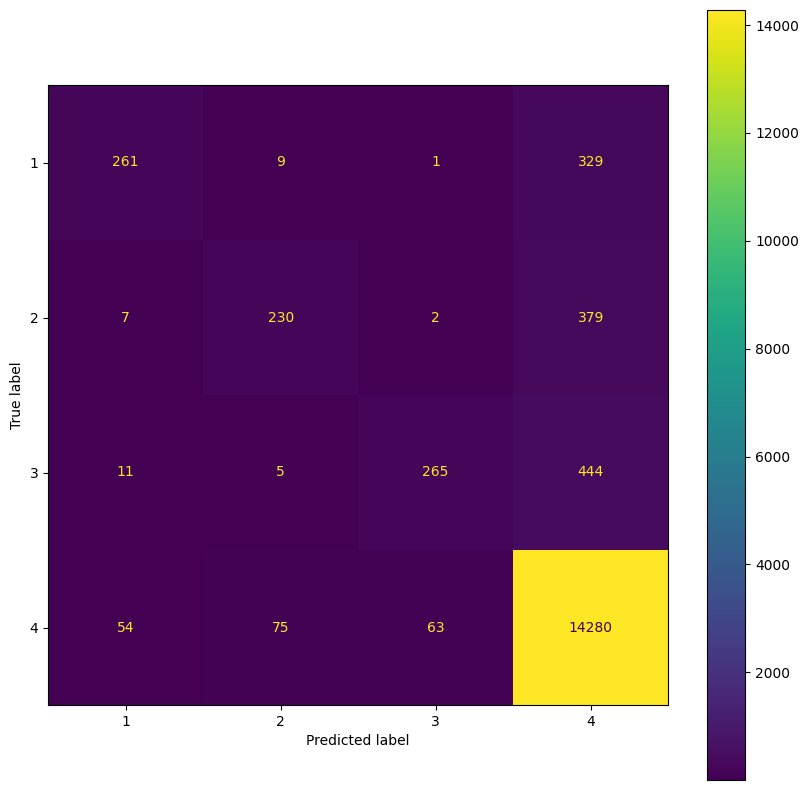

In [31]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10) 

In [32]:
balanced_accuracy_score(y_test, y_pred)

0.5398546319568323

This is the score to beat in this challenge.

In [33]:
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from imblearn.pipeline import make_pipeline as make_imb_pipeline

numerical_features = ['Age', 'Height', 'Weight', 'BMI', 'CO2', 'GDP', 'GNI', 
                      'Life_expt', 'immunization', 'mort_rate', 'population', 
                      'Number of athletes', 'Year']

categorical_features = ['Event_0', 'Event_1', 'Event_2', 'Event_3', 'Event_4', 
                        'Event_5', 'Event_6', 'Event_7', 'Event_8', 'Sport_0', 
                        'Sport_1', 'Sport_2', 'Sport_3', 'Sport_4', 'Sport_5', 
                        'Country_0', 'Country_1', 'Country_2', 'Country_3', 
                        'Country_4', 'Country_5', 'Country_6', 'Country_7',
                        'Sex_F', 'Sex_M', 'Season_Summer', 'Season_Winter']


class Classifier(BaseEstimator):
    def __init__(self):
        numeric_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ])
        
        categorical_transformer = 'passthrough'
        
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ])
        
        self.pipe = make_imb_pipeline(
            self.preprocessor,
            SMOTE(random_state=42),
            CatBoostClassifier(verbose=0)
        )

    def fit(self, X, y):
        self.pipe.fit(X, y)

    def predict(self, X):
        return self.pipe.predict(X)

    def predict_proba(self, X):
        return self.pipe.predict_proba(X)

In [34]:
!ramp-test --submission starting_kit

Testing Olympic Medal Prediction
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  bal_acc    acc      time
	train    0.219  0.053  5.219516
	valid    0.229  0.057  0.032393
	test     0.224  0.058  0.007927
CV fold 1
	score  bal_acc    acc      time
	train    0.230  0.056  3.783510
	valid    0.231  0.056  0.020825
	test     0.228  0.060  0.006004
CV fold 2
	score  bal_acc    acc      time
	train    0.227  0.054  4.141130
	valid    0.228  0.055  0.021959
	test     0.225  0.057  0.005860
----------------------------
Mean CV scores
----------------------------
	score         bal_acc             acc        time
	train  0.225 ± 0.0045  0.054 ± 0.0013  4.4 ± 0.61
	valid  0.229 ± 0.0013   0.056 ± 0.001  0.0 ± 0.01
	test   0.226 ± 0.0021  0.058 ± 0.0013   0.0 ± 0.0
----------------------------
Bagged scores
----------------------------
	score  bal_acc    acc
	valid    0.229  0.056
	test     0.227  0.058
